## Neural networks modeling

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from utils.transform_scale import transform_v2_scale_df, TARGET_VARIABLE_COLUMN

import torch
import torch.nn as nn
import torch.optim as optim

DATA_PATH = Path("data")

/Users/niharika/opt/anaconda3/envs/cs5228/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load augmented data
train_augmented = pd.read_csv(DATA_PATH / "train-augmented.csv", parse_dates=["month"])
test_augmented = pd.read_csv(DATA_PATH / "test-augmented.csv", parse_dates=["month"])

train_augmented.head()

,month,town,flat_type,block,street_name,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,...,mean_age_m,std_age_f,std_age_m,pri_sch_dist,pri_sch,sec_sch_dist,sec_sch,mall_dist,mrt_name,mrt_dist
0,2001-08-01,pasir ris,4 room,440,pasir ris drive 4,118.0,model a,uncategorized,1989,1.369008,...,36.167630,20.331631,19.999478,0.344087,Loyang Primary School,0.428301,Pasir Ris Crest Secondary School,1.033216,Pasir Ris,1.137522
1,2014-10-01,punggol,5 room,196B,punggol field,110.0,improved,uncategorized,2003,1.399007,...,31.967676,20.103889,19.793305,0.160852,Edgefield Primary School,0.312383,Meridian Secondary School,0.806040,Cove,0.118373
2,2020-09-01,sengkang,5 room,404A,fernvale lane,112.0,premium apartment,uncategorized,2004,1.388348,...,34.164736,20.311337,19.947820,0.184906,Fernvale Primary School,0.558380,Pei Hwa Secondary School,0.452556,Fernvale,0.481153
3,2000-10-01,clementi,3 room,375,clementi avenue 4,67.0,new generation,uncategorized,1980,1.318493,...,40.577282,21.625967,21.440329,0.304561,Pei Tong Primary School,0.619132,Clementi Town Secondary School,0.456499,Clementi,0.423320
4,2013-01-01,bukit batok,3 room,163,bukit batok street 11,73.0,model a,uncategorized,1985,1.348149,...,38.318241,20.497124,20.287059,0.233809,Princess Elizabeth Primary School,0.217911,Bukit Batok Secondary School,0.764172,Bukit Batok,0.774220


In [3]:
# See linear.ipynb for details - code copied from there
# Split the train data into train and test
X = train_augmented.drop(columns=TARGET_VARIABLE_COLUMN)
y = train_augmented[TARGET_VARIABLE_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Transform and scale the data
# See utils/transform_scale.py for details
X_train, X_test = transform_v2_scale_df(X_train, X_test)
X_train.head()

,month,flat_type,floor_area_sqm,flat_model,lease_commence_date,elevation,region,median_storey,distance_to_BN,distance_to_IHL,distance_to_IEBP,distance_to_CR,distance_to_market_hawker,mean_age_f,mean_age_m,pri_sch_dist,sec_sch_dist,mall_dist,mrt_dist
424394,1.247215,-0.072072,-0.594695,-1.018272,-1.407101,2.295101,-1.468284,0.669352,-1.011927,-0.715163,0.820218,0.121163,-0.737495,1.492759,1.477374,-0.077129,-0.962841,1.332660,0.516200
120565,-1.442412,1.000376,1.113372,-1.018272,-0.334238,0.073680,0.585179,-1.182206,-0.655657,0.259262,-1.665585,0.781332,0.410626,0.390655,0.458419,-0.592998,-0.980574,-1.261748,7.025002
145559,1.192325,-1.144520,-1.468591,-1.018272,-1.894766,0.496808,-1.468284,-1.182206,-1.520166,-0.994291,-0.973454,1.135453,-0.785118,1.419774,1.154660,1.656842,2.073933,-0.924956,-0.418020
132809,-0.042708,-1.144520,-0.952198,-0.231618,-0.236705,0.602590,1.269667,0.052166,0.497555,0.087701,0.758776,-0.070879,1.643412,-0.081596,0.088005,-1.044695,-0.990678,1.714609,-0.391958
32978,-0.015263,-0.072072,-0.515250,1.866128,0.641092,1.025718,-0.099309,-1.182206,1.602925,1.390263,-0.121179,-1.183845,-0.081635,-1.181189,-1.145237,0.774164,0.007730,0.202829,-0.283933


[Text(0.5302980396161818, 0.98, 'x[0] <= 0.074\nsquared_error = 16892507349.949\nsamples = 345385\nvalue = 301955.093'),
 Text(0.34362424146105697, 0.94, 'x[1] <= 0.464\nsquared_error = 7402615604.575\nsamples = 189756\nvalue = 230780.318'),
 Text(0.2206825389226334, 0.9, 'x[2] <= -0.495\nsquared_error = 3367367439.595\nsamples = 135170\nvalue = 192864.974'),
 Text(0.14410259552716934, 0.86, 'x[0] <= -0.228\nsquared_error = 1693718543.071\nsamples = 69335\nvalue = 157986.742'),
 Text(0.10009633960442268, 0.82, 'x[2] <= -0.893\nsquared_error = 1005826259.953\nsamples = 58600\nvalue = 147900.614'),
 Text(0.05356550212459111, 0.78, 'x[0] <= -0.942\nsquared_error = 690826003.721\nsamples = 46281\nvalue = 140109.016'),
 Text(0.016729859898550085, 0.74, 'x[2] <= -1.568\nsquared_error = 586381311.09\nsamples = 22536\nvalue = 129831.58'),
 Text(0.0017681902572716825, 0.7, 'x[2] <= -1.846\nsquared_error = 397888687.43\nsamples = 1327\nvalue = 86811.402'),
 Text(0.0010609141543630094, 0.66, 'x[4

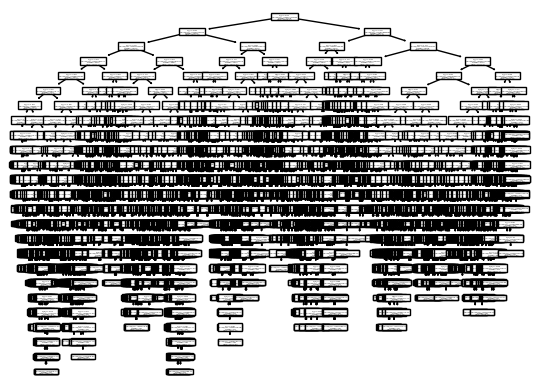

In [12]:
# Convert the data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)

# Construct a basic Decision Tree
from sklearn import tree
clf = tree.DecisionTreeRegressor(random_state=0, max_depth=50, min_samples_leaf=100)
clf = clf.fit(X_train_tensor, y_train_tensor)

tree.plot_tree(clf)

In [13]:
# Evaluate the model
with torch.no_grad():
    y_pred = clf.predict(X_test_tensor)
    print(f"Mean squared error: {mean_squared_error(y_test_tensor, y_pred)}")
    print(f"Mean absolute error: {mean_absolute_error(y_test_tensor, y_pred)}")
    print(f"R2 score: {r2_score(y_test_tensor, y_pred)}")

Mean squared error: 786995768.7309897
Mean absolute error: 19008.066694966255
R2 score: 0.9530167298281123
